In [43]:
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from dowhy import CausalModel
from numpy.random import uniform, normal, poisson, binomial, exponential, gamma, lognormal
from sklearn.neighbors import KNeighborsRegressor

In [91]:
# Hide a warning generated by the dowhy package
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [2]:
def simulate(**kwargs):
  values = {}
  g = gr.Digraph()
  for k,v in kwargs.items():
    parents = v.__code__.co_varnames
    inputs = {arg: values[arg] for arg in parents}
    values[k] = v(**inputs)
    for p in parents:
        g.edge(p,k)
  data = pd.DataFrame(values)
  return data, g

In [3]:
np.random.seed(0)

In [4]:
def dgp(N):
    return simulate(
        age = lambda: uniform(18, 80, N),
        income = lambda: normal(50000, 10000, N),
        member = lambda age, income: binomial(1, 1/(1+np.exp(-(age-40)/10)) * 1/(1+np.exp(-(income-50000)/10000)), N),
        spend = lambda member, age, income: poisson(1000 + 1000*member + 10*age - .1*age**2 + 0.01*income + 10*np.sqrt(income), N),
    )

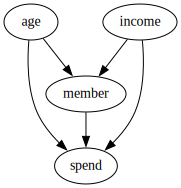

In [5]:
df, g = dgp(100)
g

# Exploratory Data Analysis

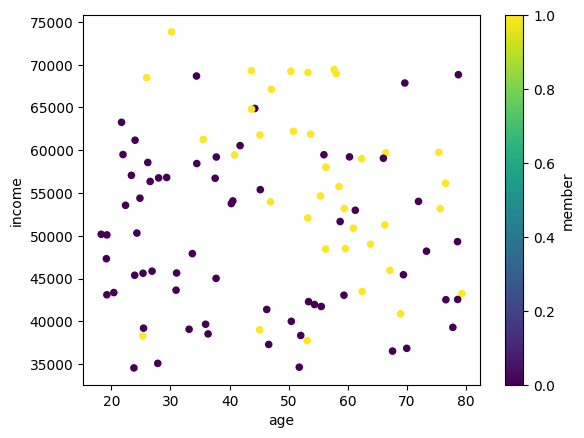

In [6]:
df.plot.scatter(x='age', y='income', c='member', colormap='viridis');

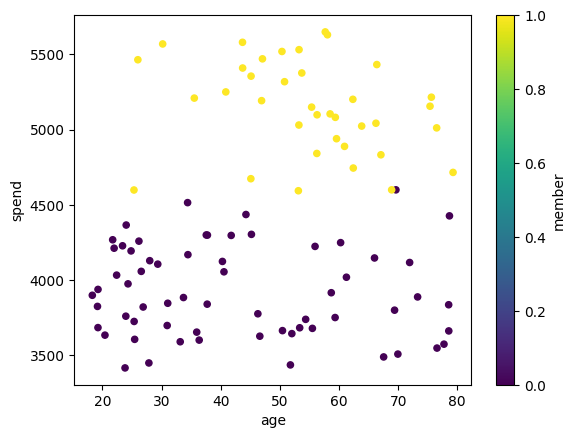

In [7]:
df.plot.scatter(x='age', y='spend', c='member', colormap='viridis');

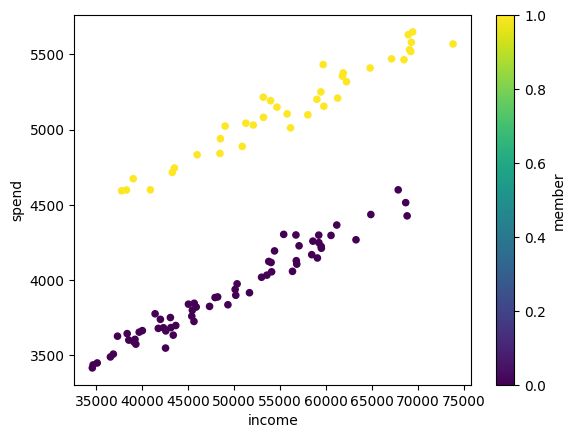

In [8]:
df.plot.scatter(x='income', y='spend', c='member', colormap='viridis');

In [9]:
# The estimated effect without controls is biased upward even if we have lots of data
df_big, _ = dgp(10000)
result = smf.ols('spend ~ member', data=df_big).fit()
print(result.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3876.4496      3.843   1008.683      0.000    3868.916    3883.983
member      1210.5046      6.882    175.883      0.000    1197.014    1223.995


# Manual Implementation of Matching

# Using Matching in R

In [30]:
# Install the package for calling R from python
#%pip install rpy2
## activate R magic
%load_ext rpy2.ipython
## Install packages in R if needed
#%R install.packages('MatchIt')

# Python to R conversion
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Read R libraries
%R library(MatchIt)
%R library(tidyverse)
%R options("width"=200, scipen=999)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


o{'width': [200], 'scipen': [0.], }

In [14]:
df.to_csv("df.csv")
df_big.to_csv("df_big.csv")

In [15]:
%%R
df <- read.csv("df.csv")
df_big <- read.csv("df_big.csv")

## Exact Matching

In [16]:
%%R
## Unfortunately, even with 10000 there are 0 exact matches
#m.exact = matchit(member ~ age + income, data = df_big, method="exact", estimand="ATE")
#summary(m.exact)

NULL


## Coarsened Exact Matching


Call:
matchit(formula = member ~ age + income, data = df_big, method = "cem", 
    estimand = "ATE", cutpoints = list(age = 10, income = 10))

Summary of Balance for All Data:
       Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean eCDF Max
age          57.1246       44.9417          0.7352     0.7386    0.1962   0.3194
income    54324.1891    48055.2427          0.6662     0.9007    0.1816   0.2698

Summary of Balance for Matched Data:
       Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean eCDF Max Std. Pair Dist.
age          48.8826       48.7942          0.0053     0.9970    0.0024   0.0097          0.1255
income    50379.8072    50009.2175          0.0394     0.9879    0.0106   0.0237          0.2554

Sample Sizes:
              Control Treated
All           6882.    3118. 
Matched (ESS) 5820.52  1594.6
Matched       6811.    3102. 
Unmatched       71.      16. 
Discarded        0.       0. 



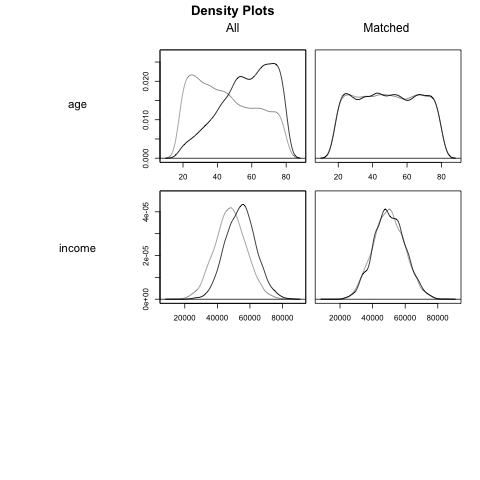

In [17]:
%%R
# Match each unit to the nearest neighbor in the other group
m_cem = matchit(
    member ~ age + income, 
    data = df_big, 
    method="cem", 
    estimand="ATE", 
    cutpoints = list(age = 10, income = 10)
)
# Prints the summary of the matching
print(summary(m_cem))
# Plot the distributions of the covariates before and after matching
plot(m_cem, type = "density")

In [18]:
%%R
df_matched_cem = match.data(m_cem)
lm(spend ~ member, data = df_matched_cem, weights = weights) %>% summary()


Call:
lm(formula = spend ~ member, data = df_matched_cem, weights = weights)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-2380.16  -205.26     6.84   203.54  2198.45 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3942.318      3.883  1015.2   <2e-16 ***
member      1012.822      6.942   145.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 320.5 on 9911 degrees of freedom
Multiple R-squared:  0.6823,	Adjusted R-squared:  0.6823 
F-statistic: 2.128e+04 on 1 and 9911 DF,  p-value: < 2.2e-16



## Matching based on Distance


Call:
matchit(formula = member ~ age + income, data = df_big, method = "nearest", 
    distance = "scaled_euclidean", estimand = "ATT")

Summary of Balance for All Data:
       Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean eCDF Max
age          57.1246       44.9417          0.7976     0.7386    0.1962   0.3194
income    54324.1891    48055.2427          0.6843     0.9007    0.1816   0.2698

Summary of Balance for Matched Data:
       Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean eCDF Max Std. Pair Dist.
age          57.1246       54.6196          0.1640     0.9836    0.0402   0.0843          0.1806
income    54324.1891    52355.7594          0.2149     1.2174    0.0560   0.1203          0.2296

Sample Sizes:
          Control Treated
All          6882    3118
Matched      3118    3118
Unmatched    3764       0
Discarded       0       0



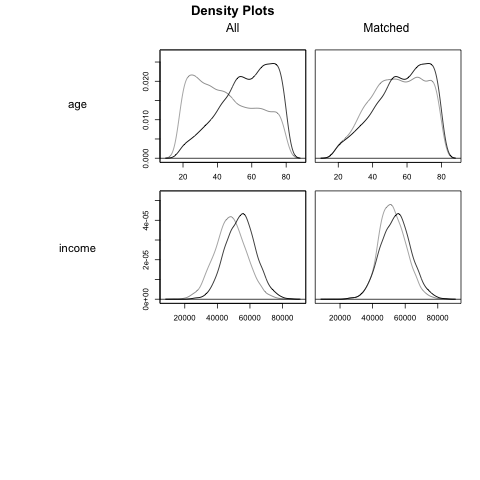

In [19]:
%%R
# Match each unit to the nearest neighbor in the other group
m_se = matchit(member ~ age + income, data = df_big, method="nearest", distance="scaled_euclidean", estimand="ATT")
# Prints the summary of the matching
print(summary(m_se))
# Plot the distributions of the covariates before and after matching
plot(m_se, type = "density")

In [20]:
%%R 
df_matched_se = match.data(m_se)
lm(spend ~ member, data = df_matched_se, weights = weights) %>% summary()


Call:
lm(formula = spend ~ member, data = df_matched_se, weights = weights)

Residuals:
     Min       1Q   Median       3Q      Max 
-1083.95  -193.95     0.05   194.60   986.05 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4028.402      5.170   779.2   <2e-16 ***
member      1058.552      7.312   144.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 288.7 on 6234 degrees of freedom
Multiple R-squared:  0.7708,	Adjusted R-squared:  0.7707 
F-statistic: 2.096e+04 on 1 and 6234 DF,  p-value: < 2.2e-16



### Mahalanobis distance


Call:
matchit(formula = member ~ age + income, data = df_big, method = "nearest", 
    distance = "mahalanobis", estimand = "ATT")

Summary of Balance for All Data:
       Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean eCDF Max
age          57.1246       44.9417          0.7976     0.7386    0.1962   0.3194
income    54324.1891    48055.2427          0.6843     0.9007    0.1816   0.2698

Summary of Balance for Matched Data:
       Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean eCDF Max Std. Pair Dist.
age          57.1246       54.6939          0.1591     0.9750    0.0390   0.0821          0.1767
income    54324.1891    52354.3015          0.2150     1.2012    0.0565   0.1196          0.2301

Sample Sizes:
          Control Treated
All          6882    3118
Matched      3118    3118
Unmatched    3764       0
Discarded       0       0



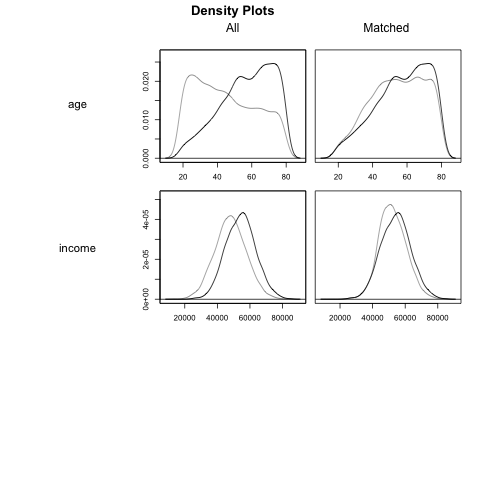

In [22]:
%%R
m_mh = matchit(member ~ age + income, data = df_big, method="nearest", distance="mahalanobis", estimand="ATT")
print(summary(m_mh))
plot(m_mh, type = "density")

In [24]:
%%R
df_matched_mh = match.data(m_mh)
lm(spend ~ member, data = df_matched_mh, weights = weights) %>% summary()


Call:
lm(formula = spend ~ member, data = df_matched_mh, weights = weights)

Residuals:
     Min       1Q   Median       3Q      Max 
-1125.02  -194.97    -0.49   195.05   986.05 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4028.018      5.185   776.9   <2e-16 ***
member      1058.936      7.332   144.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 289.5 on 6234 degrees of freedom
Multiple R-squared:  0.7699,	Adjusted R-squared:  0.7698 
F-statistic: 2.086e+04 on 1 and 6234 DF,  p-value: < 2.2e-16



## Propensity Score Matching


Call:
matchit(formula = member ~ age + income, data = df_big, distance = "glm", 
    estimand = "ATT")

Summary of Balance for All Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean eCDF Max
distance        0.4446        0.2516          0.9474     1.3883    0.2660   0.3926
age            57.1246       44.9417          0.7976     0.7386    0.1962   0.3194
income      54324.1891    48055.2427          0.6843     0.9007    0.1816   0.2698

Summary of Balance for Matched Data:
         Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean eCDF Max Std. Pair Dist.
distance        0.4446        0.3866          0.2848     1.5979    0.0516   0.1770          0.2849
age            57.1246       54.6782          0.1602     0.8127    0.0395   0.0824          0.9052
income      54324.1891    52523.1951          0.1966     1.0742    0.0526   0.0994          0.9341

Sample Sizes:
          Control Treated
All          6882    3118
Matched      3118    3118
Unm

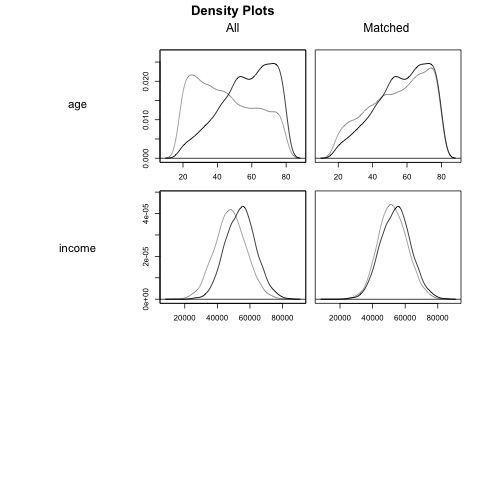

In [26]:
%%R
# Match each unit to the nearest neighbor in the other group
m_propensity = matchit(
    member ~ age + income, 
    data = df_big, 
    distance="glm",
    estimand="ATT"
)
# Prints the summary of the matching
print(summary(m_propensity))
# Plot the distributions of the covariates before and after matching
plot(m_propensity, type = "density")

In [27]:
%%R
df_matched_propensity = match.data(m_cem)
lm(spend ~ member, data = df_matched_propensity, weights = weights) %>% summary()


Call:
lm(formula = spend ~ member, data = df_matched_propensity, weights = weights)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-2380.16  -205.26     6.84   203.54  2198.45 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3942.318      3.883  1015.2   <2e-16 ***
member      1012.822      6.942   145.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 320.5 on 9911 degrees of freedom
Multiple R-squared:  0.6823,	Adjusted R-squared:  0.6823 
F-statistic: 2.128e+04 on 1 and 9911 DF,  p-value: < 2.2e-16



In [40]:
%%R
## We can improve precision by doing a regression with additional controls
lm(spend ~ member + age + income, data = df_matched_propensity, weights = weights) %>% summary()


Call:
lm(formula = spend ~ member + age + income, data = df_matched_propensity, 
    weights = weights)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-461.68  -44.99    1.19   47.06  396.40 

Coefficients:
                 Estimate    Std. Error t value             Pr(>|t|)    
(Intercept) 2306.18168915    4.41177450 522.733 < 0.0000000000000002 ***
member      1000.74778897    1.57560670 635.151 < 0.0000000000000002 ***
age            0.18317797    0.04074436   4.496           0.00000701 ***
income         0.03253797    0.00007615 427.269 < 0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 72.73 on 9909 degrees of freedom
Multiple R-squared:  0.9836,	Adjusted R-squared:  0.9836 
F-statistic: 1.986e+05 on 3 and 9909 DF,  p-value: < 0.00000000000000022



In [39]:
%%R
## What if we do regression with the exact right specification?
lm(spend ~ member + poly(age,2,raw=TRUE) + income + sqrt(income), data = df_matched_propensity, weights = weights) %>% summary()


Call:
lm(formula = spend ~ member + poly(age, 2, raw = TRUE) + income + 
    sqrt(income), data = df_matched_propensity, weights = weights)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-326.40  -40.36    1.26   41.22  417.37 

Coefficients:
                             Estimate  Std. Error t value            Pr(>|t|)    
(Intercept)                988.713261   49.820463  19.846 <0.0000000000000002 ***
member                    1000.484730    1.404161 712.514 <0.0000000000000002 ***
poly(age, 2, raw = TRUE)1   10.296140    0.224744  45.813 <0.0000000000000002 ***
poly(age, 2, raw = TRUE)2   -0.103363    0.002269 -45.561 <0.0000000000000002 ***
income                       0.009831    0.001017   9.668 <0.0000000000000002 ***
sqrt(income)                10.059563    0.450002  22.354 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 64.81 on 9907 degrees of freedom
Multiple R-squared:  0.987,	Adjusted R-sq

# Matching and IPW in Python

## Manual distance based matching

In [42]:
df, _ = dgp(1000)
X = ["income", "age"]
T = "member"
y = "spend"
treated = df[df[T] == 1]
untreated = df[df[T] == 0]

knn0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[X], untreated[y])
knn1 = KNeighborsRegressor(n_neighbors=1).fit(treated[X], treated[y])

predicted = pd.concat([
    treated.assign(match=knn0.predict(treated[X])),
    untreated.assign(match=knn1.predict(untreated[X]))
])

# Make sure we are always subtracting the untreated from the treated
predicted["te"] = np.where(
    predicted[T] == 1, 
    predicted[y] - predicted["match"], 
    predicted["match"] - predicted[y]
)
print(np.mean(predicted["te"]))

# Alternative formula to do caluclation in one step
print(np.mean((2*predicted[T] - 1)*(predicted[y] - predicted["match"])))

1002.426
1002.426


## Matching and IPW in DoWhy

In [60]:
# Some of the methods complains if the treatment is not explicitly marked as binary
df_big=df_big.astype({'member':'bool'}, copy=False)

model = CausalModel(
    data = df_big,
    treatment = 'member',
    outcome = 'spend',
    graph = g.__str__()
)

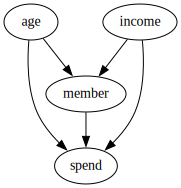

In [51]:
g

In [61]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                         
─────────(E[spend|age,income])
d[member]                     
Estimand assumption 1, Unconfoundedness: If U→{member} and U→spend then P(spend|member,age,income,U) = P(spend|member,age,income)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Linear Regression Adjustment

In [100]:
estimate = model.estimate_effect(estimand, method_name="backdoor.linear_regression")
print(f"Causal Estimate with linear regression is {estimate.value} with confidence interval {estimate.get_confidence_intervals()}")

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
Causal Estimate with linear regression is 1003.3424733804482 with confidence interval [[ 999.91317767 1006.77176909]]


### Distance based Matching

In [101]:
estimate = model.estimate_effect(
    estimand, 
    method_name="backdoor.distance_matching",
    target_units="ate",
    method_params={'distance_metric':"minkowski", 'p':2},
)
print(f"Causal Estimate with distance-based matching is {estimate.value}")
# Confidence intervals are slow to compute for distance-based matching
#print(f"Causal Estimate with distance-based matching is {estimate.value} with confidence interval {estimate.get_confidence_intervals()}")

distance_matching


### Propensity Matching

In [98]:
estimate = model.estimate_effect(
    estimand, 
    method_name="backdoor.propensity_score_matching",
    target_units="ate",
)
print(f"Causal Estimate with distance-based matching is {estimate.value}")

# Confidence intervals are slow since they need to repeatedly fit the propensity score model
#estimate.get_confidence_intervals()

propensity_score_matching
Causal Estimate with distance-based matching is 1197.604


### Inverse Propensity Score Weighting

In [94]:
estimate = model.estimate_effect(
    estimand, 
    method_name="backdoor.propensity_score_weighting",
    target_units="ate",
    method_params={"weighting_scheme":"ips_stabilized_weight"},
)
print(f"Causal Estimate with distance-based matching is {estimate.value}")

propensity_score_weighting
Causal Estimate with distance-based matching is 1282.9259859218314


In [93]:
# Redo propensity score estimation using XGboost to estimate propensities
from xgboost import XGBClassifier
estimate = model.estimate_effect(
    estimand, 
    method_name="backdoor.propensity_score_weighting",
    
    target_units="ate",
    method_params={
        "weighting_scheme":"ips_stabilized_weight",
        "propensity_model":XGBClassifier()
    },
)
print(f"Causal Estimate with distance-based matching is {estimate.value}")

propensity_score_weighting
Causal Estimate with distance-based matching is 1282.9259859218314


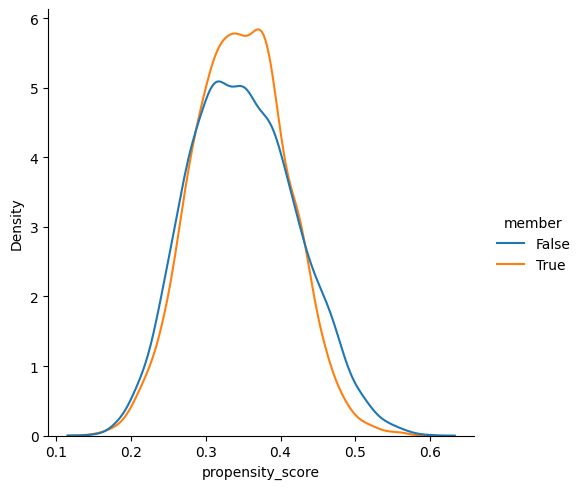

In [86]:
sns.displot(df_big, x="propensity_score", hue="member", kind="kde", common_norm=False)